# **Generating Monet Style Pictures with CycleGAN**

This project explores generative techniques utilizing CycleGAN to transform regular images into Monet-style artworks. By leveraging the power of generative models, the goal is to capture the distinctive artistic features of Monet's style and demonstrate the potential of generative models in different applications. We will use a dataset provided by Kaggle, which includes Monet paintings and regular photographs. The model will be trained on the Monet-style images to learn the distinct artistic features of Monet's work.

The dataset can be found here: https://www.kaggle.com/competitions/gan-getting-started/data

### **Data and EDA**

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
from google.colab import files

# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"irinatilak","key":"175bd9e5d584452eb53ed105c8ea0899"}'}

In [3]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c gan-getting-started

 97% 356M/367M [00:04<00:00, 59.7MB/s]
100% 367M/367M [00:04<00:00, 87.1MB/s]


In [5]:
import zipfile

zip_path = "gan-getting-started.zip"
output_dir = "gan-monet-images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

In [6]:
!ls /content/gan-monet-images

monet_jpg  monet_tfrec	photo_jpg  photo_tfrec


In [7]:
#!ls /content/gan-monet-images/photo_jpg/

In [8]:
monet_path = "/content/gan-monet-images/monet_jpg"
photo_path = "/content/gan-monet-images/photo_jpg"

def count_images(folder_path):
    return len([f for f in os.listdir(folder_path) if f.endswith('.jpg')])

num_monet_images = count_images(monet_path)
num_photo_images = count_images(photo_path)

In [9]:
num_monet_images, num_photo_images

(300, 7038)

In [10]:
def get_image_sizes(folder_path):
    sizes = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):
            filepath = os.path.join(folder_path, filename)
            try:
                with Image.open(filepath) as img:
                    sizes.append(img.size)
            except Exception as e:
                print(f"Error with {filename}: {e}")
    return sizes

# Get sizes for Monet and Photo images
monet_sizes = get_image_sizes(monet_path)
photo_sizes = get_image_sizes(photo_path)

In [11]:
np.unique(monet_sizes), np.unique(photo_sizes)

(array([256]), array([256]))

### **Data Processing**

In [12]:
import random
import shutil

**I initially started with 300 images but had to reduce the dataset to 50 due to GPU memory limitations. To accommodate this, I also decreased the image size and batch size. However, the resulting images were overly grainy. To address this, I attempted to increase the dataset size to 100 images, but GPU memory constraints resurfaced, requiring yet another reduction in batch size.**

In [13]:
sample_size = 100

In [14]:
# Sampling photos
photo_original_path = "/content/gan-monet-images/photo_jpg"
photo_sampled_path = "/content/gan-monet-images/photo_sampled_jpg"

# Function to randomly sample images
def sample_images(input_folder, output_folder, sample_size):
    os.makedirs(output_folder, exist_ok=True)  # Create the output folder if it doesn't exist
    all_images = [f for f in os.listdir(input_folder) if f.endswith('.jpg')]
    sampled_images = random.sample(all_images, min(len(all_images), sample_size))
    for image in sampled_images:
        shutil.copy(os.path.join(input_folder, image), os.path.join(output_folder, image))
    return sampled_images

sampled_images_photo = sample_images(photo_original_path, photo_sampled_path, sample_size)

In [15]:
monet_original_path = "/content/gan-monet-images/monet_jpg"
monet_sampled_path = "/content/gan-monet-images/monet_sampled_jpg"

# Function to randomly sample images
def sample_images(input_folder, output_folder, sample_size):
    os.makedirs(output_folder, exist_ok=True)  # Create the output folder if it doesn't exist
    all_images = [f for f in os.listdir(input_folder) if f.endswith('.jpg')]
    sampled_images = random.sample(all_images, min(len(all_images), sample_size))
    for image in sampled_images:
        shutil.copy(os.path.join(input_folder, image), os.path.join(output_folder, image))
    return sampled_images

sampled_images_monet = sample_images(monet_original_path, monet_sampled_path, sample_size)

**I resized images from 256x256 to 128x128 due to GPU memory issue. Also, for the same reason, reduced batch size twice - from 16 to 8, and then to 4**

In [16]:
img_hight = 128
img_weight = 128
batch_size = 4

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_hight, img_weight])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

# Function to load the dataset
def load_image_dataset(folder_path):
    image_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith('.jpg')]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(len(image_paths))  # Shuffle all images in memory
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

monet_dataset = load_image_dataset(monet_sampled_path)
photo_dataset = load_image_dataset(photo_sampled_path)

### **Training**

In [17]:
train_on_gpu = True

**Using Instance Normalization layer in CycleGAN model architecture, learning rate scheduler and ResNet Generator**
- ResNet helps with vanishing gradients challenges
- learning rate scheduler is helpful for dynamically adjusting the learning rate during training to improve convergence and prevent overfitting
- Insatnce Normalization helps models focus on content-independent style transformations

In [18]:
# Instance Normalization Layer
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=(input_shape[-1],), initializer="ones", trainable=True
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],), initializer="zeros", trainable=True
        )

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        return self.gamma * (inputs - mean) / tf.sqrt(variance + self.epsilon) + self.beta


# Residual Block
def residual_block(x, filters):
    initializer = tf.random_normal_initializer(0., 0.02)

    # First layer
    res = layers.Conv2D(filters, kernel_size=3, strides=1, padding="same", kernel_initializer=initializer)(x)
    res = InstanceNormalization()(res)
    res = layers.ReLU()(res)

    # Second layer
    res = layers.Conv2D(filters, kernel_size=3, strides=1, padding="same", kernel_initializer=initializer)(res)
    res = InstanceNormalization()(res)

    return layers.add([x, res])


# ResNet Generator
def resnet_generator(image_size=128, n_residual_blocks=9):
    initializer = tf.random_normal_initializer(0., 0.02)

    inputs = layers.Input(shape=(image_size, image_size, 3))

    # Initial Convolutional Layer
    x = layers.Conv2D(64, kernel_size=7, strides=1, padding="same", kernel_initializer=initializer)(inputs)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    # Downsampling
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same", kernel_initializer=initializer)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same", kernel_initializer=initializer)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    # Residual Blocks
    for _ in range(n_residual_blocks):
        x = residual_block(x, 128)

    # Upsampling
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", kernel_initializer=initializer)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", kernel_initializer=initializer)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    # Output Layer
    outputs = layers.Conv2D(3, kernel_size=7, strides=1, padding="same", kernel_initializer=initializer, activation="tanh")(x)

    return tf.keras.Model(inputs, outputs, name="ResNet_Generator")

In [19]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Set limit (e.g., 4GB)
    except RuntimeError as e:
        print(e)

Virtual devices cannot be modified after being initialized


In [20]:
generator_g = resnet_generator(image_size=128, n_residual_blocks=6)
generator_f = resnet_generator(image_size=128, n_residual_blocks=6)

In [21]:
generator_g.summary()

Model: "ResNet_Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ instance_normalization    │ (None, 128, 128, 64)   │            128 │ conv2d[0][0]           │
│ (InstanceNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 128, 128, 64)   │              0 │ instance_normalizatio… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ instance_normalization_1  │ (None, 64, 64, 128)    │            256 │ conv2d_1[0][0]         │
│ (InstanceNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 64, 64, 128)    │              0 │ instance_normalizatio… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ instance_normalization_2  │ (None, 32, 32, 128)    │            256 │ conv2d_2[0][0]         │
│ (InstanceNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 32, 32, 128)    │              0 │ instance_normalizatio… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ instance_normalization_3  │ (None, 32, 32, 128)    │            256 │ conv2d_3[0][0]         │
│ (InstanceNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 32, 32, 128)    │              0 │ instance_normalizatio… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ instance_normalization_4  │ (None, 32, 32, 128)    │            256 │ conv2d_4[0][0]         │
│ (InstanceNormalization)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 128)    │              0 │ re_lu_2[0][0],         │
│                           │                        │                │ instance_normalizatio… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)    

 Total params: 2,236,803 (8.53 MB)

 Trainable params: 2,236,803 (8.53 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

In [23]:
class LinearDecay(LearningRateSchedule):
    def __init__(self, initial_lr, decay_start_epoch, total_epochs):
        super(LinearDecay, self).__init__()
        self.initial_lr = initial_lr
        self.decay_start_epoch = decay_start_epoch
        self.total_epochs = total_epochs

    def __call__(self, epoch):
        if epoch < self.decay_start_epoch:
            return self.initial_lr
        else:
            decay_factor = (self.total_epochs - epoch) / (self.total_epochs - self.decay_start_epoch)
            return self.initial_lr * max(decay_factor, 0.0)

In [24]:
initial_lr = 2e-4
decay_start_epoch = 10
total_epochs = 25

In [25]:
lr_schedule = LinearDecay(initial_lr, decay_start_epoch, total_epochs)

In [26]:
generator_g_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5)

In [27]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inputs = layers.Input(shape=[128, 128, 3])

    # Downsampling layers
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same', kernel_initializer=initializer)(inputs)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Output layer
    outputs = layers.Conv2D(1, kernel_size=4, strides=1, padding='same', kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs, outputs, name="PatchGAN_Discriminator")

In [28]:
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

In [29]:
# Adversarial Loss
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

# Cycle Consistency Loss
def cycle_consistency_loss(real, cycled):
    return tf.reduce_mean(tf.abs(real - cycled))

# Identity Loss
def identity_loss(real, same):
    return tf.reduce_mean(tf.abs(real - same))

In [30]:
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generate images
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Identity mapping
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Discriminator outputs
        disc_real_x = discriminator_x(real_x, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)

        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Loss calculations
        gen_g_loss = (generator_loss(disc_fake_y) +
                      cycle_consistency_loss(real_x, cycled_x) * 10 +
                      identity_loss(real_y, same_y) * 5)

        gen_f_loss = (generator_loss(disc_fake_x) +
                      cycle_consistency_loss(real_y, cycled_y) * 10 +
                      identity_loss(real_x, same_x) * 5)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_g_gradients = tape.gradient(gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

**This was my first model on 50 images sample**

In [69]:
import time

for epoch in range(total_epochs):
    start = time.time()

    for real_photo, real_monet in tf.data.Dataset.zip((photo_dataset, monet_dataset)):
        train_step(real_photo, real_monet)

    print(f"Epoch {epoch + 1}/{total_epochs} completed in {time.time() - start:.2f} seconds.")


Epoch 1/25 completed in 18.06 seconds.
Epoch 2/25 completed in 20.47 seconds.
Epoch 3/25 completed in 14.54 seconds.
Epoch 4/25 completed in 14.41 seconds.
Epoch 5/25 completed in 20.48 seconds.
Epoch 6/25 completed in 14.13 seconds.
Epoch 7/25 completed in 14.31 seconds.
Epoch 8/25 completed in 20.48 seconds.
Epoch 9/25 completed in 14.21 seconds.


Epoch 10/25 completed in 14.23 seconds.
Epoch 11/25 completed in 20.48 seconds.
Epoch 12/25 completed in 14.42 seconds.
Epoch 13/25 completed in 20.48 seconds.
Epoch 14/25 completed in 14.26 seconds.
Epoch 15/25 completed in 14.11 seconds.
Epoch 16/25 completed in 14.12 seconds.
Epoch 17/25 completed in 20.48 seconds.
Epoch 18/25 completed in 14.21 seconds.
Epoch 19/25 completed in 14.22 seconds.


Epoch 20/25 completed in 20.48 seconds.
Epoch 21/25 completed in 14.12 seconds.
Epoch 22/25 completed in 14.31 seconds.
Epoch 23/25 completed in 20.48 seconds.
Epoch 24/25 completed in 14.16 seconds.
Epoch 25/25 completed in 14.19 seconds.


**This is the result**

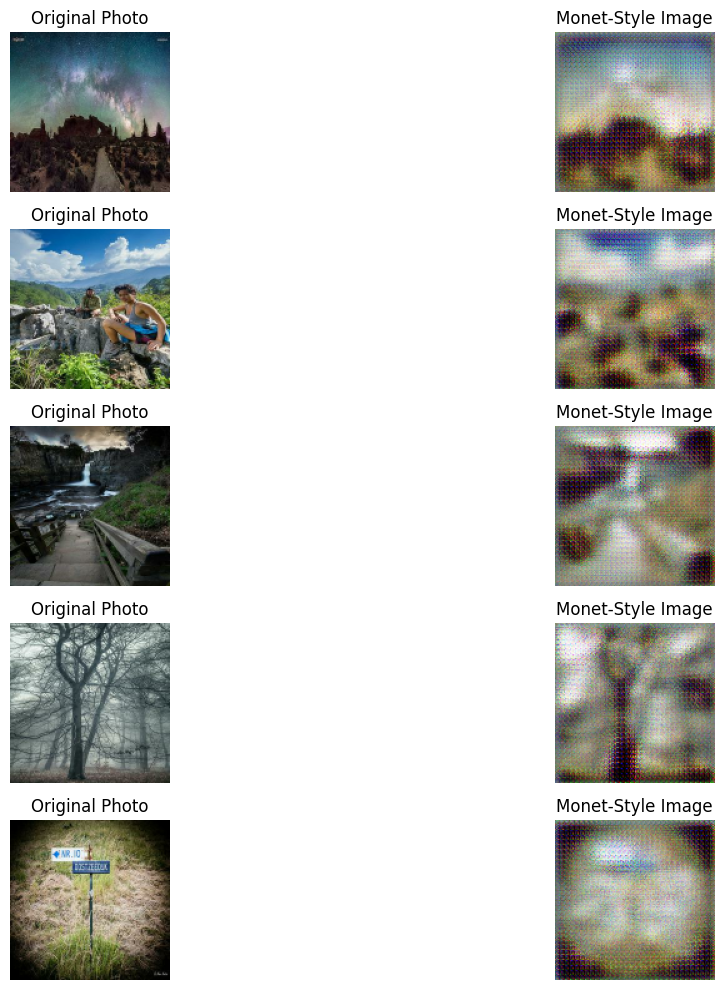

In [71]:
def compare_photos_with_monet(generator, photo_dataset, num_images=5):
    """
    Compares original photos with Monet-style images side by side.
    Args:
        generator: Trained generator model (Photo → Monet).
        photo_dataset: Dataset of real photos.
        num_images: Number of images to visualize.
    """
    plt.figure(figsize=(15, 10))
    for i, photo in enumerate(photo_dataset.take(num_images)):

        generated_image = generator(photo, training=False)[0].numpy()
        generated_image = (generated_image * 127.5 + 127.5).astype('uint8')  # De-normalize

        original_photo = photo[0].numpy()
        original_photo = (original_photo * 127.5 + 127.5).astype('uint8')  # De-normalize

        plt.subplot(num_images, 2, i * 2 + 1)
        plt.imshow(original_photo)
        plt.title("Original Photo")
        plt.axis("off")

        plt.subplot(num_images, 2, i * 2 + 2)
        plt.imshow(generated_image)
        plt.title("Monet-Style Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

compare_photos_with_monet(generator_g, photo_dataset, num_images=5)

**The images are very grainy. I decided to increase the sample size from 50 to 100, but reduce the batch size from 8 to 4 because I was running out of GPU memory again**

In [31]:
import time

for epoch in range(total_epochs):
    start = time.time()

    for real_photo, real_monet in tf.data.Dataset.zip((photo_dataset, monet_dataset)):
        train_step(real_photo, real_monet)

    print(f"Epoch {epoch + 1}/{total_epochs} completed in {time.time() - start:.2f} seconds.")

Epoch 1/25 completed in 81.95 seconds.
Epoch 2/25 completed in 81.92 seconds.
Epoch 3/25 completed in 48.21 seconds.
Epoch 4/25 completed in 81.92 seconds.
Epoch 5/25 completed in 47.84 seconds.
Epoch 6/25 completed in 47.82 seconds.
Epoch 7/25 completed in 81.92 seconds.
Epoch 8/25 completed in 81.92 seconds.
Epoch 9/25 completed in 47.14 seconds.
Epoch 10/25 completed in 47.26 seconds.
Epoch 11/25 completed in 47.58 seconds.
Epoch 12/25 completed in 47.39 seconds.
Epoch 13/25 completed in 47.17 seconds.
Epoch 14/25 completed in 47.29 seconds.
Epoch 15/25 completed in 46.45 seconds.
Epoch 16/25 completed in 47.08 seconds.
Epoch 17/25 completed in 47.29 seconds.
Epoch 18/25 completed in 47.31 seconds.
Epoch 19/25 completed in 47.51 seconds.
Epoch 20/25 completed in 47.43 seconds.
Epoch 21/25 completed in 81.92 seconds.
Epoch 22/25 completed in 46.70 seconds.
Epoch 23/25 completed in 47.39 seconds.
Epoch 24/25 completed in 47.32 seconds.
Epoch 25/25 completed in 47.25 seconds.


**This is the result of the model trained on 100 images. While there seems to be some improvement, with more details becoming noticeable, the enhancement is not very significant. It could be worthwhile to experiment further by increasing the size of the training dataset and the number of epochs (if GPU memory allows for it).**

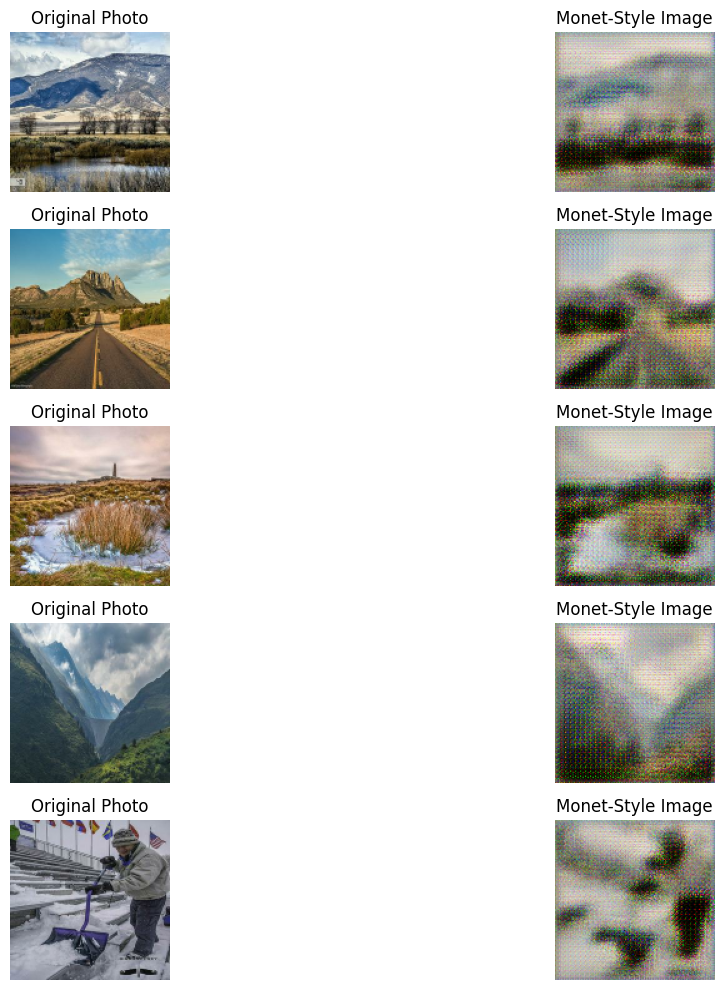

In [32]:
def compare_photos_with_monet(generator, photo_dataset, num_images=5):

    plt.figure(figsize=(15, 10))
    for i, photo in enumerate(photo_dataset.take(num_images)):

        generated_image = generator(photo, training=False)[0].numpy()
        generated_image = (generated_image * 127.5 + 127.5).astype('uint8')  # De-normalize

        original_photo = photo[0].numpy()
        original_photo = (original_photo * 127.5 + 127.5).astype('uint8')  # De-normalize

        plt.subplot(num_images, 2, i * 2 + 1)
        plt.imshow(original_photo)
        plt.title("Original Photo")
        plt.axis("off")

        plt.subplot(num_images, 2, i * 2 + 2)
        plt.imshow(generated_image)
        plt.title("Monet-Style Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

compare_photos_with_monet(generator_g, photo_dataset, num_images=5)

**Saving generated images**

In [33]:
def save_generated_images(generator, photo_dataset, output_dir, num_images=10):

    os.makedirs(output_dir, exist_ok=True)
    for i, image in enumerate(photo_dataset.take(num_images)):

        generated_image = generator(image, training=False)[0].numpy()
        generated_image = (generated_image * 127.5 + 127.5).astype('uint8')  # De-normalize

        output_path = os.path.join(output_dir, f"monet_style_{i + 1}.jpg")
        Image.fromarray(generated_image).save(output_path)
    print(f"Generated images saved to: {output_dir}")

save_generated_images(generator_g, photo_dataset, output_dir="./monet_images", num_images=10)

Generated images saved to: ./monet_images


### **Conclusion**
This project explored the implementation of a CycleGAN model, aiming to transform photos into Monet-style paintings. Due to GPU memory limitations, the training process faced significant constraints, including a reduced training set (initially 50 images), smaller image sizes, and batch sizes. The generated images from the 50-image training set exhibited a noticeable grainy texture, likely due to insufficient data for capturing Monet's artistic style.

An attempt to improve results by increasing the training set to 100 images was interrupted at the 21st epoch (out of 25) due to resource exhaustion, requiring a reduction in batch size from 8 to 4. The results showed only minor improvements, suggesting the need for further experimentation with training set size and a higher number of epochs. These challenges underscore the importance of sufficient computational resources and larger datasets for achieving high-quality style transfer. Future efforts could focus on addressing these limitations by utilizing more powerful hardware, refining the model architecture, and exploring data augmentation or alternative training strategies to achieve better outcomes.